# Introduction: linear regression

This notebook is an introduction to the probabilistic modelling (PM) workflow for building energy use prediction.

It is also an introduction to PyMC, the easiest library to get started with PM in Python. More advanced users may want to try Stan as well, which is covered in [the book related to this notebook](https://buildingenergygeeks.org/). PyMC integrates well with ArviZ, a library for visualizations and diagnostics of Bayesian models.

This first tutorial uses a simple linear regression model to demonstrate the workflow of Bayesian modelling, including prior and posterior predictive checks.

## The data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

The data are two years of monthly energy consumption of a school, along with two independent variables: heating degree days (HDD) and number of class days.

The first half of the data is labeled `pre` and will be used for training. The second half is labeled `post` and will be used for validating model forecasts.

In [2]:
df = pd.read_csv('data/pmva.csv', sep=";", decimal=",")
df.head()

,observation,consumption,HDD,CLASSDAYS,period
0,1,321120,12.7,0.0,pre
1,2,335520,19.4,6.0,pre
2,3,412560,147.6,20.0,pre
3,4,394560,353.4,20.0,pre
4,5,424080,526.7,20.0,pre


Text(0.5, 0, 'classdays')

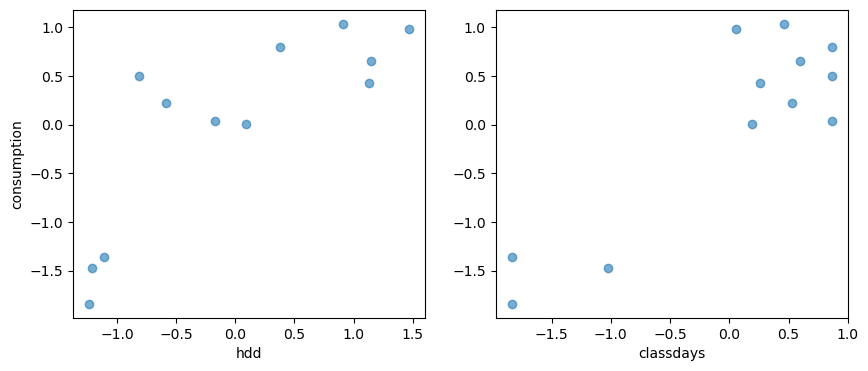

In [3]:
df_train = df[df['period']=="pre"]
df_test = df[df['period']=="post"]

# inputs and outputs, normalized
X1 = (df_train['HDD'] - df_train['HDD'].mean()) / df_train['HDD'].std()
X2 = (df_train['CLASSDAYS'] - df_train['CLASSDAYS'].mean()) / df_train['CLASSDAYS'].std()
Y = (df_train['consumption'] - df_train['consumption'].mean()) / df_train['consumption'].std()

# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("hdd")
axes[1].set_xlabel("classdays")

##  Model specification

We will attempt to predict the energy consumption $y$ by a linear function of HDD $x_1$ and classdays $x_2$.

$$ y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \varepsilon $$

with $\varepsilon \sim N(0, \sigma)$. This is equivalent to writing:

$$ y \sim \mathcal{N} \left( \alpha + \beta_1 x_1 + \beta_2 x_2 \; , \sigma \right)$$

We are therefore looking for four parameters $(\alpha, \beta_1, \beta_2, \sigma)$.

The methodology below follows [PyMC's introductory overview](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html).

This is the model, written with PyMC:

In [4]:
model1 = pm.Model()

with model1:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=[1, 1], sigma=[1, 1], shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

### Prior predictive sampling

The first three lines of the model above define prior distributions for each of the three parameters $(\alpha, \beta_1, \beta_2, \sigma)$. This step is optional but highly recommended in any Bayesian workflow.

Before we proceed further, we can see look at the model's output if it only draws from these priors. This step is called prior predictive sampling, and allows checking if the model is consistent. Prior predictive checks help you check how credible your assumptions before seeing the data are.

In [8]:
with model1:
    priordata = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


idata is an [InferenceData object from the ArviZ library](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html). It is a multidimensional xarray that you can visualize and explore by displaying it in Jupyter:

In [10]:
# priordata

Text(0.5, 0, 'i_sol')

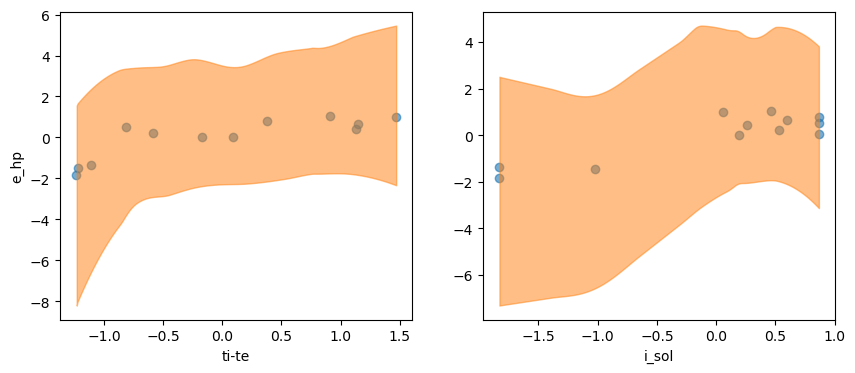

In [9]:
# The same plot as before but with the predictions drawn from the prior
yprior = priordata.prior_predictive['Y_obs']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1, Y, alpha=0.6)
#axes[0].plot(X1, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
#axes[0].plot(X1, yprior.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, yprior, ax=axes[0])
axes[0].set_xlabel("ti-te")
axes[0].set_ylabel("e_hp")

axes[1].scatter(X2, Y, alpha=0.6)
#axes[1].plot(X2, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
az.plot_hdi(X2, yprior, ax=axes[1])
axes[1].set_xlabel("i_sol")

The orange area shows the Highest Density Interval of the prior predictive distribution, which is the minimum width [Credible Interval](https://en.wikipedia.org/wiki/Credible_interval) of a certain probability. Ideally, most of the data should be comprised in it for the initial model to be consistent.

### Model fitting

In Bayesian terms, model "fitting" is called **conditioning** the model on the data.

In [11]:
with model1:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an InferenceData object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that sample generated a set of parallel chains, depending on how many compute cores are on your machine.

`idata` is an `InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data.

You can access the trace of one parameter from idata by uncommenting the second line below:

In [12]:
idata
#idata.posterior["alpha"]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Model checking

PyMC's plotting and diagnosis functionalities are taken care of by a dedicated package named Arviz. A simple posterior plot can be created using plot_trace:

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

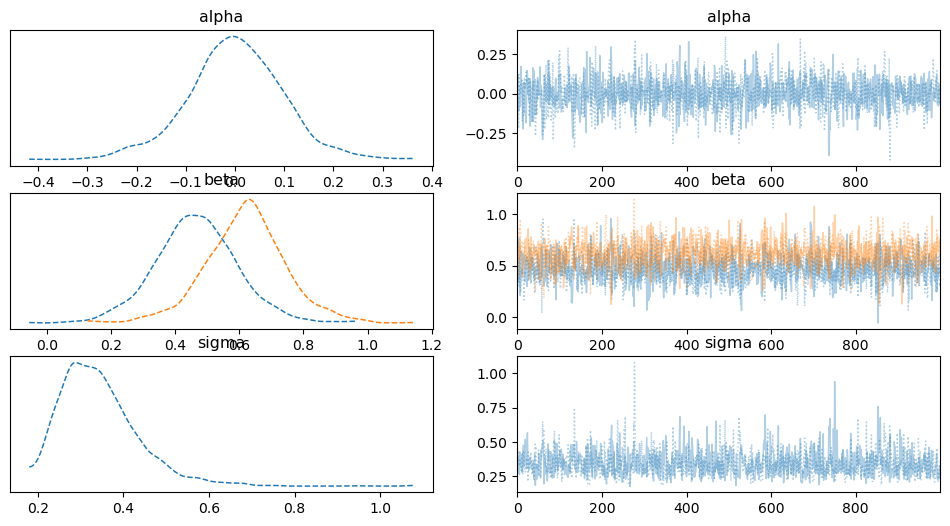

In [13]:
az.plot_trace(idata, combined=True)

In addition, the summary function provides a text-based output of common posterior statistics.

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.098,-0.182,0.205,0.002,0.002,1603.0,1071.0,1.0
beta[0],0.466,0.128,0.221,0.713,0.004,0.003,1229.0,1235.0,1.0
beta[1],0.619,0.126,0.394,0.891,0.004,0.003,1203.0,1031.0,1.0
sigma,0.343,0.092,0.201,0.511,0.003,0.002,894.0,797.0,1.0


Other possible diagnosis plots:

* An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution.
* plot_forest is designed to handle vector-valued parameters.

In [17]:
# az.plot_energy(idata)
# az.plot_forest(idata, combined=True, hdi_prob=0.95, r_hat=True)

### Posterior predictive checking

PyMC has a dedicated function to sample data from the posterior. The `extend_inferencedata=True` option allows saving posterior_prediction within the existing idata object

In [18]:
with model1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [Y_obs]


Now, the posterior_predictive group in idata contains 4000 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:

In [19]:
idata.posterior

<xarray.Dataset> Size: 72kB
Dimensions:     (chain: 2, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 16B 0 1
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 16B 0 1
Data variables:
    alpha       (chain, draw) float64 16kB -0.09697 0.1241 ... -0.06943 -0.07438
    beta        (chain, draw, beta_dim_0) float64 32kB 0.5691 0.557 ... 0.7956
    sigma       (chain, draw) float64 16kB 0.4133 0.3389 0.383 ... 0.3413 0.3562
Attributes:
    created_at:                 2024-04-24T09:19:22.657458
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              2.2809481620788574
    tuning_steps:               1000

A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

Alternatively, we can also display the posterior predictive intervals as we did after prior sampling:

Text(0.5, 0, 'i_sol')

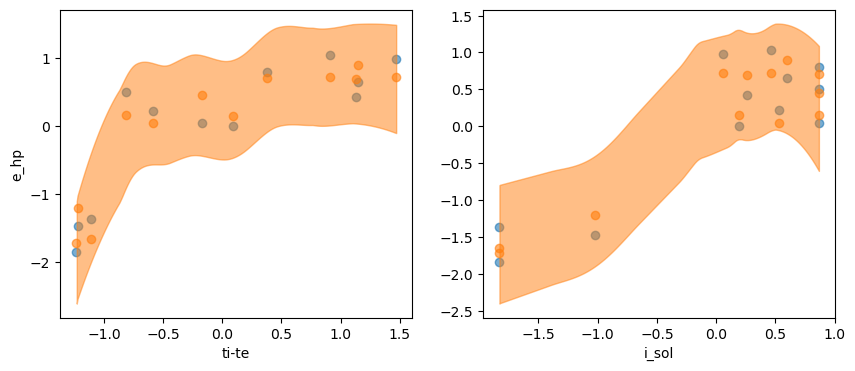

In [20]:
y_post = idata.posterior_predictive["Y_obs"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1, Y, alpha=0.6)
axes[0].scatter(X1, y_post.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, y_post, ax=axes[0])
axes[0].set_xlabel("ti-te")
axes[0].set_ylabel("e_hp")

axes[1].scatter(X2, Y, alpha=0.6)
axes[1].scatter(X2, y_post.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X2, y_post, ax=axes[1])
axes[1].set_xlabel("i_sol")

Displaying the autocorrelation of residuals:

<Axes: title={'center': 'x\n0'}>

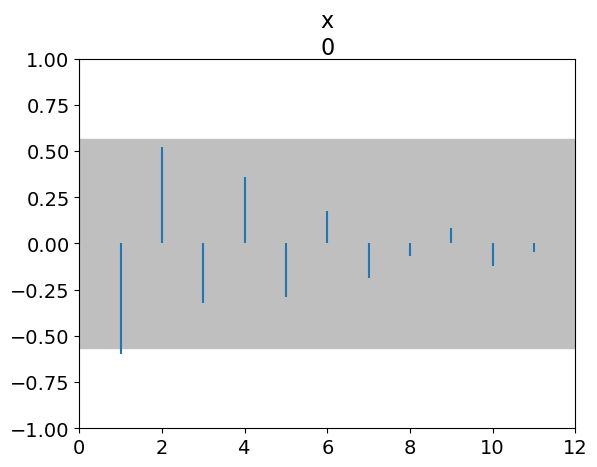

In [21]:
resid = Y - y_post.mean(("chain", "draw"))
#resid
az.plot_autocorr(resid.values)

## Forecasting

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

In [22]:
X1_test = (df_test['HDD'] - df_test['HDD'].mean()) / df_test['HDD'].std()
X2_test = (df_test['CLASSDAYS'] - df_test['CLASSDAYS'].mean()) / df_test['CLASSDAYS'].std()
Y_test = (df_test['consumption'] - df_test['consumption'].mean()) / df_test['consumption'].std()

In [23]:
import xarray as xr

Y_pred = idata.posterior["alpha"] + idata.posterior["beta"][:,:,0] * xr.DataArray(X1_test) + idata.posterior["beta"][:,:,1] * xr.DataArray(X2_test)

Text(0.5, 0, 'i_sol')

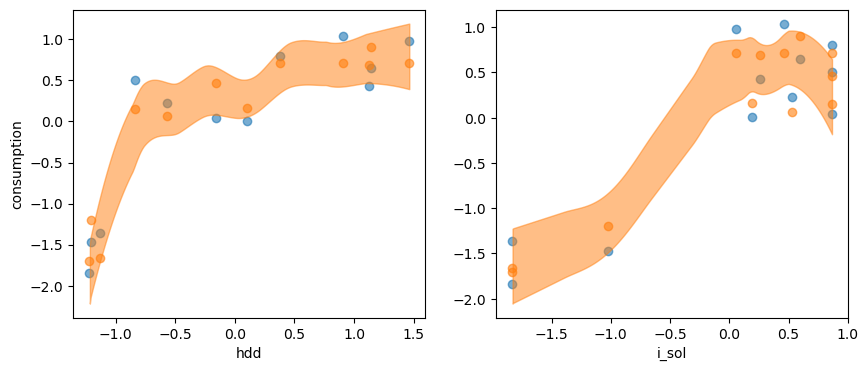

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1_test, Y_test, alpha=0.6)
axes[0].scatter(X1_test, Y_pred.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1_test, Y_pred, ax=axes[0])
axes[0].set_xlabel("hdd")
axes[0].set_ylabel("consumption")

axes[1].scatter(X2_test, Y_test, alpha=0.6)
axes[1].scatter(X2_test, Y_pred.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X2_test, Y_pred, ax=axes[1])
axes[1].set_xlabel("i_sol")